In [1]:
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [14]:
raw_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
#sub_df = pd.read_csv(data_dir+'sample_submission.csv')

In [15]:
input_cols = raw_df.columns.tolist()
input_cols.remove('label')

In [16]:
target_col = 'label'

In [17]:
for col in input_cols:
    raw_df[col] = raw_df[col]/255

In [18]:
input_tensor = torch.tensor(raw_df[input_cols].values, dtype=torch.float32)
target_tensor = torch.tensor(raw_df[target_col].values)

In [19]:
raw_ds = TensorDataset(input_tensor, target_tensor)

tensor(9)


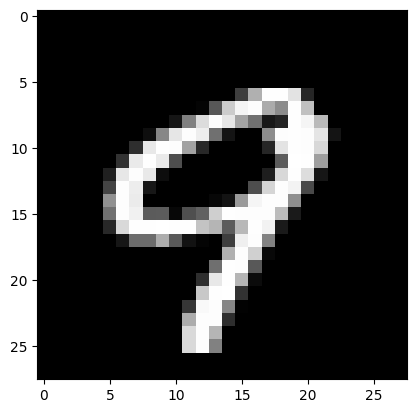

In [20]:
image_sample = raw_ds[100][0].reshape(28, 28)
import matplotlib.pyplot as plt
print(raw_ds[100][1])
plt.imshow(image_sample, cmap='gray')

In [21]:
random_seed = 42
torch.manual_seed(random_seed)

In [22]:
val_size = 8000
train_size = len(raw_ds) - val_size

In [23]:
batch_size = 128

In [24]:
def accurary(output, target):
    _, pred = torch.max(output, dim=1)
    return torch.tensor(torch.sum(pred==target).item()/len(target))

In [25]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        out = self(images)
        loss = F.cross_entropy(out, targets)
        acc = accurary(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [26]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)
get_default_device()

device(type='cpu')

In [27]:
input_tensor = input_tensor.reshape(-1, 1, 28, 28)

raw_ds = TensorDataset(input_tensor, target_tensor)
raw_ds[0][0].shape

torch.Size([1, 28, 28])

In [28]:
input_tensor = T.Resize((32, 32))(input_tensor)

In [ ]:
raw_ds = TensorDataset(input_tensor, target_tensor)
raw_ds[0][0].shape

tensor(9)


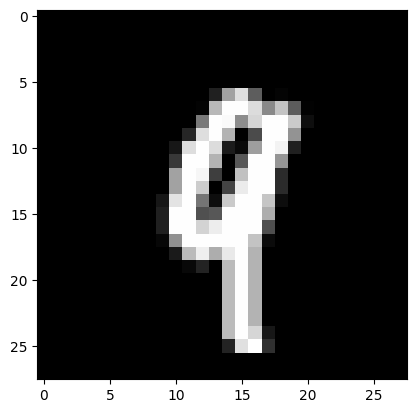

In [29]:
image_sample = raw_ds[501][0].permute(1, 2, 0)
import matplotlib.pyplot as plt
print(raw_ds[501][1])
plt.imshow(image_sample, cmap='gray')

In [30]:
train_ds, val_ds = random_split(raw_ds, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=6, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=6, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [31]:
train_dl = DeviceDataLoader(train_dl, get_default_device())
val_dl = DeviceDataLoader(val_dl, get_default_device())

In [32]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [33]:
class CNNModel(BaseModel):
    def __init__(self):
        super().__init__()

        self.prep = conv_block(1, 64)
        self.layer1 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.layer2 = conv_block(128, 256, pool=True)
        self.layer3 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, 10))

    def forward(self, xb):
        out = self.prep(xb)
        out = self.layer1(out)
        out = self.res1(out) + out
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [34]:
CNNModel()

CNNModel(
  (prep): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=T

In [35]:
cnn_model = to_device(CNNModel(), get_default_device())

In [36]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

In [37]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [38]:
def fit_cnn(epochs, lr, model, train_dl, val_dl, opt_func=torch.optim.SGD,
            weight_decay=0,grad_clip=None):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                                steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            sched.step()
        # Validation
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [42]:
%%time
history = [evaluate(cnn_model, val_dl)]
history

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


RuntimeError: Given input size: (512x3x3). Calculated output size: (512x0x0). Output size is too small

In [41]:
%%time
history += fit_cnn(15, 0.01, cnn_model, train_dl, val_dl, opt_func=torch.optim.Adam,
                   weight_decay=1e-4, grad_clip=0.1)

NameError: name 'history' is not defined

In [ ]:
test_df[input_cols] = test_df[input_cols]/255
test_input_tensors = torch.tensor(test_df[input_cols].values, dtype=torch.float32)
test_input_tensors = test_input_tensors.reshape(-1, 1, 28, 28)
test_input_tensors = T.Resize((32, 32))(test_input_tensors)
test_ds = TensorDataset(test_input_tensors)
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), get_default_device())
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
image_sample = test_ds[0][0].permute(1, 2, 0)
print(predict_image(test_ds[0][0], cnn_model))
plt.imshow(image_sample, cmap='gray')

In [ ]:
for i in range(len(test_ds)):
    sub_df.loc[i, 'Label'] = predict_image(test_ds[i][0], cnn_model)
sub_df.to_csv('/kaggle/working/submission.csv', index=False)